In [9]:
%reload_ext autoreload
%autoreload 2

In [10]:
from src.cifar_autoencoder import CifarDataSet, AutoEncoder, train
from torch.utils.data import DataLoader

In [11]:
m = AutoEncoder()

In [12]:
train_ds = CifarDataSet(
            batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", train=True
        )
test_ds = CifarDataSet(
    batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", train=False
)

In [13]:
tl = DataLoader(test_ds,batch_size=64)

In [14]:
ops = train(m, tl, 2)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:1, Loss:0.0748


100%|██████████| 157/157 [06:58<00:00,  2.66s/it]

Epoch:2, Loss:0.0182


In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
all_losses = []
index = 0
for i,x in ops[-1]:
    all_losses.append({"counter":index,"epoch":i+1,"iteration":index+1,"loss":x})
    index+=1

In [17]:
loss_df = pd.DataFrame(all_losses)

<AxesSubplot:xlabel='counter', ylabel='loss'>

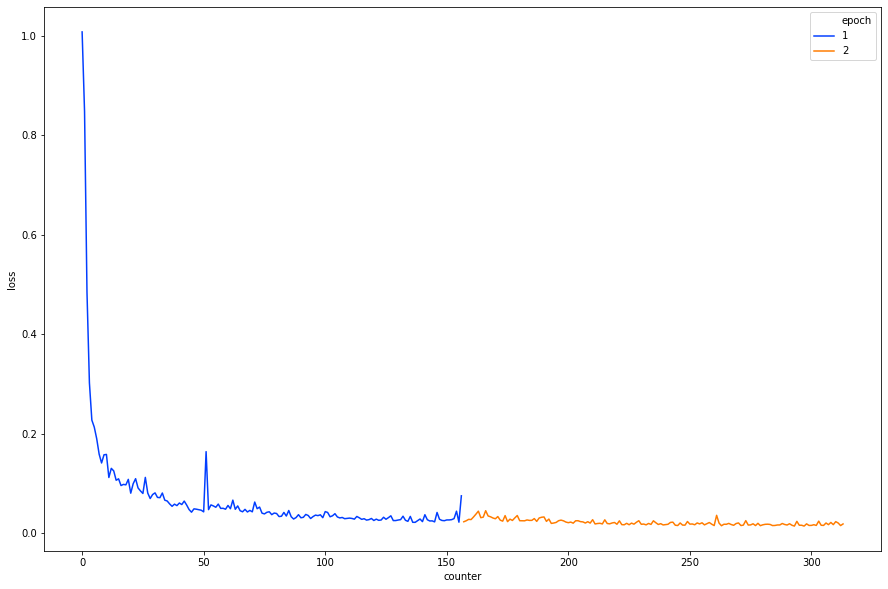

In [18]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

In [23]:
imgs = ops[0][-1][1].reshape(-1,3,32,32).numpy()

In [24]:
imgs = imgs.transpose(0,2,3,1)

In [25]:
pred = ops[0][-1][2].reshape(-1,3,32,32).detach().numpy()

In [26]:
pred = pred.transpose(0,2,3,1)

In [30]:
index = 10

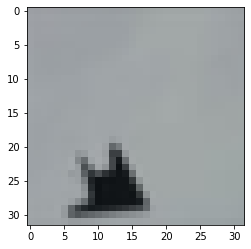

In [31]:
plt.imshow(imgs[index])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


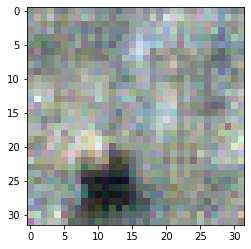

In [32]:
plt.imshow(pred[index])